In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

from data import (
    load_dataset,
    dataset_info,
    summary_statistics,
    general_health_to_numeric,
    age_category_to_numeric,
    binary_columns_to_numeric,
    checkup_to_numeric,
    preprocess,
    plot_numeric_distributions,
    plot_normality_qq,
    plot_categorical_distributions
)

from regression import (
    run_logistic_regression,
    run_xgboost
)

df = load_dataset("data/data.csv")

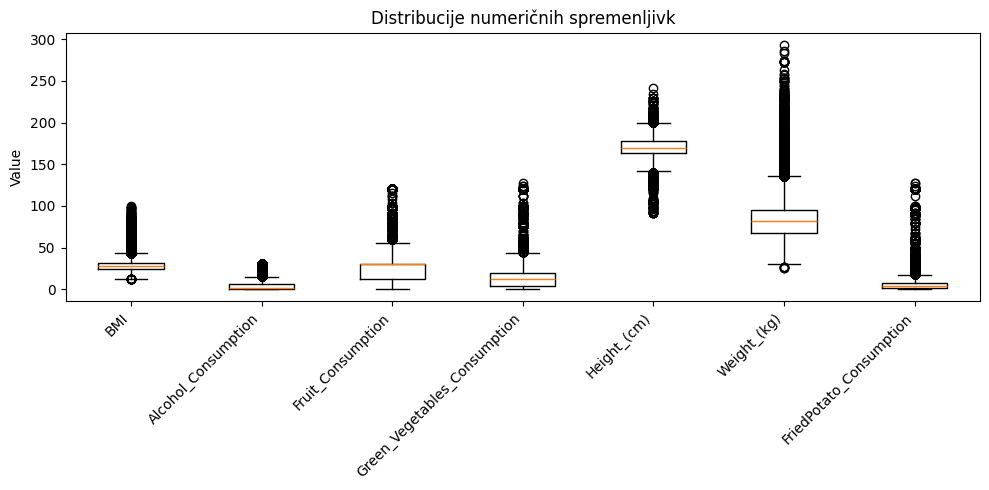

In [2]:
plot_numeric_distributions(df)

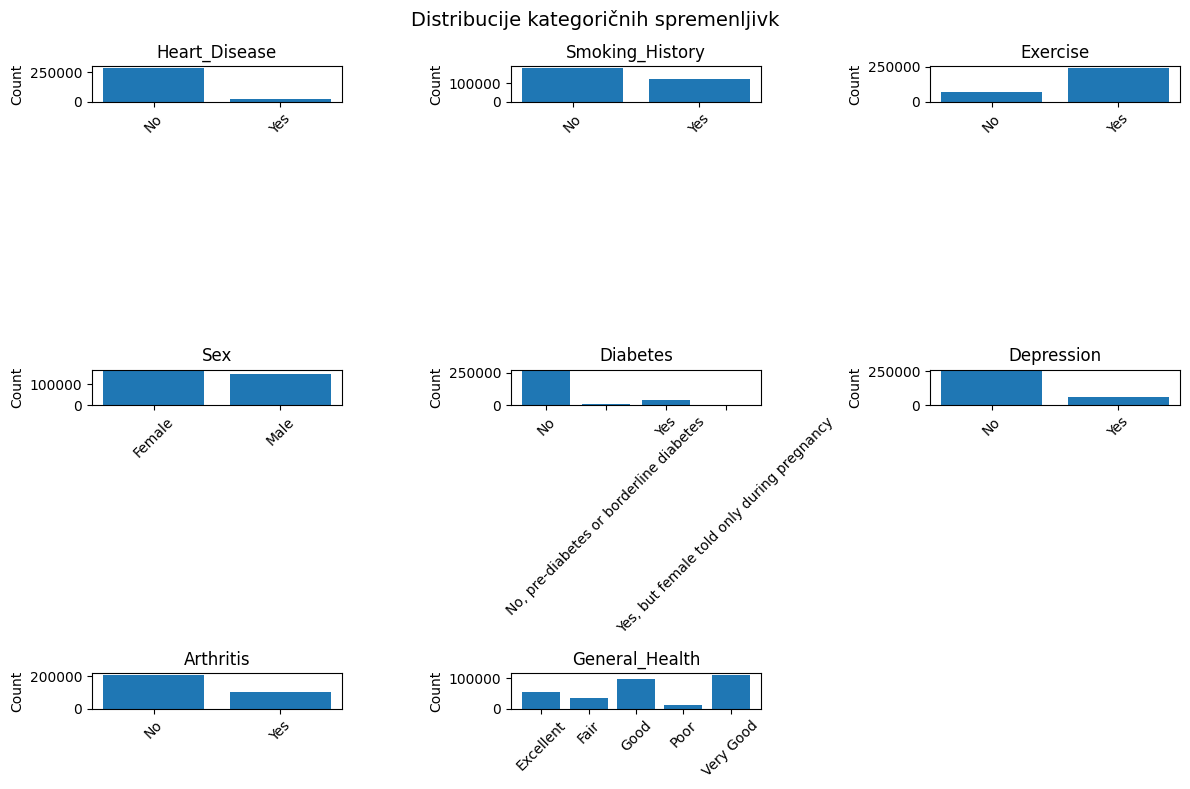

In [3]:
plot_categorical_distributions(df)

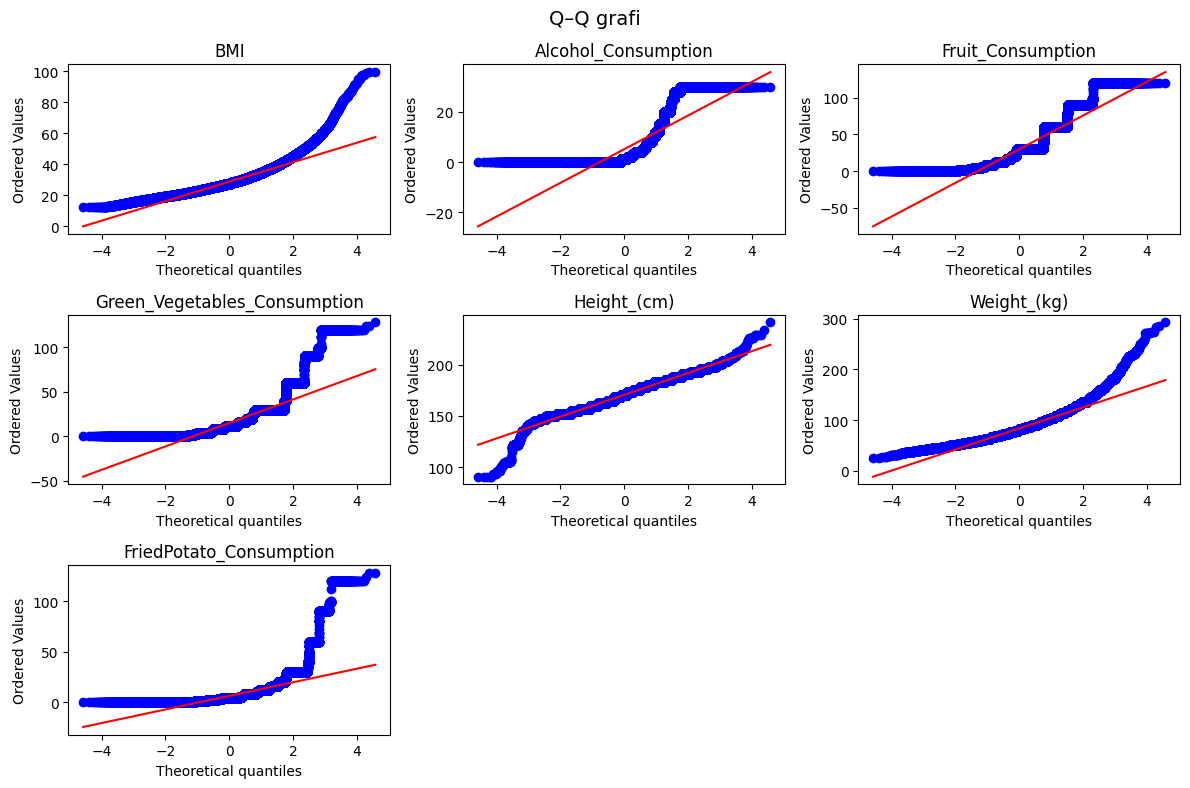

In [4]:
plot_normality_qq(df)

In [5]:
df = preprocess(df)
model, X, summary_df = run_logistic_regression(df)
summary_df

,Feature,Coefficient,Std_Error,Odds_Ratio,CI_2.5%,CI_97.5%,z_value,p_value
Sex,Sex,0.766004,0.015627,2.151154,2.086268,2.218058,49.019114,0.000000
Diabetes,Diabetes,0.535090,0.016908,1.707601,1.651939,1.765139,31.646584,0.000000
Smoking_History,Smoking_History,0.395245,0.015043,1.484748,1.441612,1.529175,26.274903,0.000000
Checkup,Checkup,0.356629,0.024418,1.428505,1.361750,1.498533,14.605333,0.000000
Arthritis,Arthritis,0.270865,0.015573,1.311098,1.271685,1.351732,17.393541,0.000000
Depression,Depression,0.253361,0.018445,1.288348,1.242603,1.335777,13.735731,0.000000
Age_Category,Age_Category,0.056468,0.000638,1.058093,1.056771,1.059416,88.545648,0.000000
BMI,BMI,0.002826,0.001172,1.002830,1.000528,1.005137,2.409997,0.015953
Green_Vegetables_Consumption,Green_Vegetables_Consumption,0.000859,0.000540,1.000859,0.999801,1.001918,1.591352,0.111530
Fruit_Consumption,Fruit_Consumption,0.000035,0.000316,1.000035,0.999416,1.000655,0.111409,0.911292


In [6]:
xgb_model, xgb_importance_df, auc = run_xgboost(df)
print(f"XGBoost ROC AUC: {auc:.3f}")
xgb_importance_df

XGBoost ROC AUC: 0.833


,Feature,Importance
13,General_Health,0.251814
0,Age_Category,0.227983
1,Sex,0.144582
9,Diabetes,0.121236
2,Smoking_History,0.056477
11,Arthritis,0.050067
12,Checkup,0.035668
10,Depression,0.023794
4,Alcohol_Consumption,0.016828
3,Exercise,0.016095
